In [ ]:
# ===================================================================
# 共通セットアップセル (ローカル / Colab 共通)
# ===================================================================
import sys
import os
from pathlib import Path

# --- 1. 環境判別 ---
IN_COLAB = False
try:
    # Colab環境でのみインポートが成功する
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    pass # ローカル環境


if IN_COLAB:
    # ==================================
    # Colab 環境でのセットアップ
    # ==================================
    print("環境: Colab を検出。セットアップを開始します。")

    # 1. Google Driveのマウント
    drive.mount('/content/drive')

    # 2. GitHubリポジトリのクローンまたはプル
    repo_path = Path('/content/braidyn-bc')
    if repo_path.exists():
        print("リポジトリを pull します...")
        os.chdir(repo_path)
        !git pull
    else:
        print("リポジトリを clone します...")
        !git clone https://github.com/nyaamikeneko/braidyn-bc.git
        os.chdir(repo_path)

    # 3. 依存ライブラリのインストール
    print("依存ライブラリをインストールします...")
    !pip install -q pynwb git+https://github.com/BraiDyn-BC/bdbc-nwb-explorer.git

    # 4. sys.path の設定
    project_root = repo_path
    if str(project_root) not in sys.path:
        sys.path.append(str(project_root))

    print(f"セットアップ完了。プロジェクトルート: {project_root}")

else:
    # ==================================
    # ローカル (VSCode) 環境でのセットアップ
    # ==================================
    print("環境: ローカル (VSCode) を検出。")

    # 1. sys.path の設定
    current_dir = Path.cwd()
    if current_dir.name == 'notebooks':
        # ノートブックが notebooks/ から実行された場合
        project_root = current_dir.parent
    else:
        # プロジェクトルート (braidyn-bc/) から実行されたと仮定
        project_root = current_dir

    if str(project_root) not in sys.path:
        sys.path.append(str(project_root))

    print(f"プロジェクトルート: {project_root}")

# ===================================================================
# 共通インポート・処理
# (セットアップが完了したため、config.py や src/ が読み込める)
# ===================================================================
print("\n共通モジュールをインポートします...")

import bdbc_nwb_explorer as nwbx
import src.data_loader as dl
import config  # config.py もここで読み込める

print(f"データパス (DATA_NWB_ROOT): {config.DATA_NWB_ROOT}")

In [ ]:
# --- 必要なデータを関数で読み出す ---
SESSION_ID = "VG1GC-105"
NWB_FILENAME = "VG1GC-105_2024-02-02_task-day8.nwb"
TASK_DAY_DIR = "task-day8"

# NWBデータの読み込み
# (dl は共通セルでインポート済み)
session = dl.load_nwb_session(SESSION_ID, NWB_FILENAME)

# CSVデータの読み込み
trials = dl.load_trials_csv(SESSION_ID, TASK_DAY_DIR)

# これ以降、 session や trials を使った分析処理を記述...
if trials is not None:
    print(trials.head())

ValueError: Could not interpret value `day` for `x`. An entry with this name does not appear in `data`.

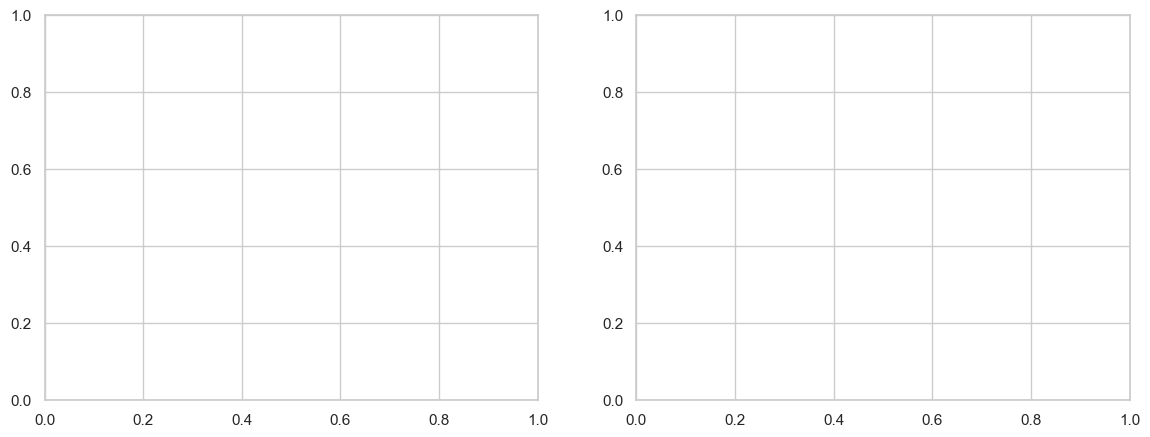

In [4]:
"""
DAY ごとの「音無しレバー引き」試行数とレバー引き長さを
  • 7 匹すべてのマウスについて
  • day 1–15 で
可視化するスクリプト
------------------------------------------------------------
* 音無しレバー引き  : (state_task == 0) かつ diff_value > 0.4
* レバー引き長さ    :
                      無ければ diff_value を代用
------------------------------------------------------------
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ---------- 設定 ----------
mice_ids   = ["51", "53", "105", "63", "61", "66", "48"]
days       = range(1, 16)                        # day 1–15
csv_root   = Path("/content/drive/MyDrive/hackathon_data")
sns.set(style="whitegrid")

records = []   # ← 集計結果を入れるリスト

# ---------- データ収集 ----------
for mid in mice_ids:
    for day in days:
        csv_path = csv_root / f"VG1GC-{mid}" / f"task-day{day}" / "trials_L1L2.csv"
        if not csv_path.exists():
            continue

        df = pd.read_csv(csv_path)

        # --- 音無しレバー引き試行を抽出 ---
        mask = (df["state_task"] == 0) & (df["diff_value"] > 0.034)
        df_nosound = df.loc[mask]

        if df_nosound.empty:
            continue

        # --- レバー引きの「長さ」列を決定 ---
        dur_col = "diff_value"

        records.append({
            "mouse": mid,
            "day"  : day,
            "n_trials": len(df_nosound),
            "pull_len_mean": df_nosound[dur_col].mean(),
            "pull_len_sem" : df_nosound[dur_col].std(ddof=1) / (len(df_nosound)**0.5)
        })

# ---------- DataFrame 化 ----------
res = pd.DataFrame(records)

# ---------- 可視化 ----------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ① 試行数の推移
sns.lineplot(data=res, x="day", y="n_trials", hue="mouse",
             marker="o", ax=axes[0])
axes[0].set_title("音無しレバー引き試行数 (day1–15)")
axes[0].set_xlabel("Day")
axes[0].set_ylabel("Trials / day")

# ② レバー引き長さの推移（平均±SEM）
for mid, grp in res.groupby("mouse"):
    axes[1].errorbar(grp["day"], grp["pull_len_mean"],
                     yerr=grp["pull_len_sem"],
                     marker="o", label=mid, capsize=3)
axes[1].set_title("音無しレバー引き長さ (平均±SEM)")
axes[1].set_xlabel("Day")
axes[1].set_ylabel("Pull length (s)")
axes[1].legend(title="mouse")

plt.tight_layout()
plt.show()

# ---------- 有意差検定（例：day1 vs day15 のペア t 検定, 各マウスごと） ----------
from scipy.stats import ttest_rel

print("\n--- day1 vs day15 : pull_len_mean, paired t-test ---")
for mid in mice_ids:
    g = res.query("mouse == @mid and day in [1, 15]")
    if len(g) == 2:
        t, p = ttest_rel(g.sort_values("day")["pull_len_mean"].values,
                         g.sort_values("day")["pull_len_mean"].values[::-1])
        print(f"mouse {mid}: p = {p:.4f}")
    else:
        print(f"mouse {mid}: data incomplete")


<ipython-input-88-2905c99d89e9>:76: UserWarning: Glyph 38899 (\N{CJK UNIFIED IDEOGRAPH-97F3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-88-2905c99d89e9>:76: UserWarning: Glyph 28961 (\N{CJK UNIFIED IDEOGRAPH-7121}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-88-2905c99d89e9>:76: UserWarning: Glyph 12375 (\N{HIRAGANA LETTER SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-88-2905c99d89e9>:76: UserWarning: Glyph 12524 (\N{KATAKANA LETTER RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-88-2905c99d89e9>:76: UserWarning: Glyph 12496 (\N{KATAKANA LETTER BA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-88-2905c99d89e9>:76: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-88-2905c99d89e9>:76: UserWarning: Glyph 24341 (\N{CJK UNIFIED IDEOGRAPH-5F15}) missing from font(s) Dej

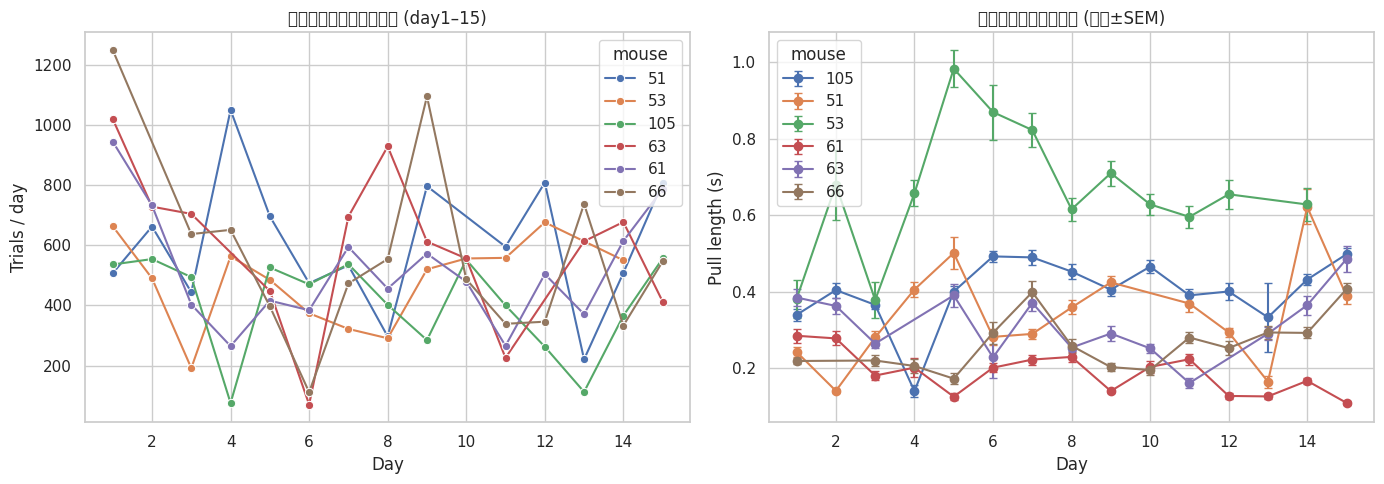


--- day1 vs day15 : pull_len_mean, paired t-test ---
mouse 51: p = 1.0000
mouse 53: data incomplete
mouse 105: p = 1.0000
mouse 63: p = 1.0000
mouse 61: p = 1.0000
mouse 66: p = 1.0000
mouse 48: data incomplete


In [ ]:
"""
DAY ごとの「音無しレバー引き」試行数とレバー引き長さを
  • 7 匹すべてのマウスについて
  • day 1–15 で
可視化するスクリプト
------------------------------------------------------------
* 音無しレバー引き  : (state_task == 0) かつ diff_value > 0.00
* レバー引き長さ    :
                      無ければ diff_value を代用
------------------------------------------------------------
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ---------- 設定 ----------
mice_ids   = ["51", "53", "105", "63", "61", "66", "48"]
days       = range(1, 16)                        # day 1–15
csv_root   = Path("/content/drive/MyDrive/hackathon_data")
sns.set(style="whitegrid")

records = []   # ← 集計結果を入れるリスト

# ---------- データ収集 ----------
for mid in mice_ids:
    for day in days:
        csv_path = csv_root / f"VG1GC-{mid}" / f"task-day{day}" / "trials_L1L2.csv"
        if not csv_path.exists():
            continue

        df = pd.read_csv(csv_path)

        # --- 音無しレバー引き試行を抽出 ---
        mask = (df["state_task"] == 0) & (df["diff_value"] > 0.0)
        df_nosound = df.loc[mask]

        if df_nosound.empty:
            continue

        # --- レバー引きの「長さ」列を決定 ---
        dur_col = "diff_value"

        records.append({
            "mouse": mid,
            "day"  : day,
            "n_trials": len(df_nosound),
            "pull_len_mean": df_nosound[dur_col].mean(),
            "pull_len_sem" : df_nosound[dur_col].std(ddof=1) / (len(df_nosound)**0.5)
        })

# ---------- DataFrame 化 ----------
res = pd.DataFrame(records)

# ---------- 可視化 ----------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ① 試行数の推移
sns.lineplot(data=res, x="day", y="n_trials", hue="mouse",
             marker="o", ax=axes[0])
axes[0].set_title("音無しレバー引き試行数 (day1–15)")
axes[0].set_xlabel("Day")
axes[0].set_ylabel("Trials / day")

# ② レバー引き長さの推移（平均±SEM）
for mid, grp in res.groupby("mouse"):
    axes[1].errorbar(grp["day"], grp["pull_len_mean"],
                     yerr=grp["pull_len_sem"],
                     marker="o", label=mid, capsize=3)
axes[1].set_title("音無しレバー引き長さ (平均±SEM)")
axes[1].set_xlabel("Day")
axes[1].set_ylabel("Pull length (s)")
axes[1].legend(title="mouse")

plt.tight_layout()
plt.show()

# ---------- 有意差検定（例：day1 vs day15 のペア t 検定, 各マウスごと） ----------
from scipy.stats import ttest_rel

print("\n--- day1 vs day15 : pull_len_mean, paired t-test ---")
for mid in mice_ids:
    g = res.query("mouse == @mid and day in [1, 15]")
    if len(g) == 2:
        t, p = ttest_rel(g.sort_values("day")["pull_len_mean"].values,
                         g.sort_values("day")["pull_len_mean"].values[::-1])
        print(f"mouse {mid}: p = {p:.4f}")
    else:
        print(f"mouse {mid}: data incomplete")


<ipython-input-71-89dc19aaacf7>:18: UserWarning: Glyph 38899 (\N{CJK UNIFIED IDEOGRAPH-97F3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-71-89dc19aaacf7>:18: UserWarning: Glyph 28961 (\N{CJK UNIFIED IDEOGRAPH-7121}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-71-89dc19aaacf7>:18: UserWarning: Glyph 12375 (\N{HIRAGANA LETTER SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-71-89dc19aaacf7>:18: UserWarning: Glyph 12524 (\N{KATAKANA LETTER RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-71-89dc19aaacf7>:18: UserWarning: Glyph 12496 (\N{KATAKANA LETTER BA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-71-89dc19aaacf7>:18: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-71-89dc19aaacf7>:18: UserWarning: Glyph 24341 (\N{CJK UNIFIED IDEOGRAPH-5F15}) missing from font(s) Dej

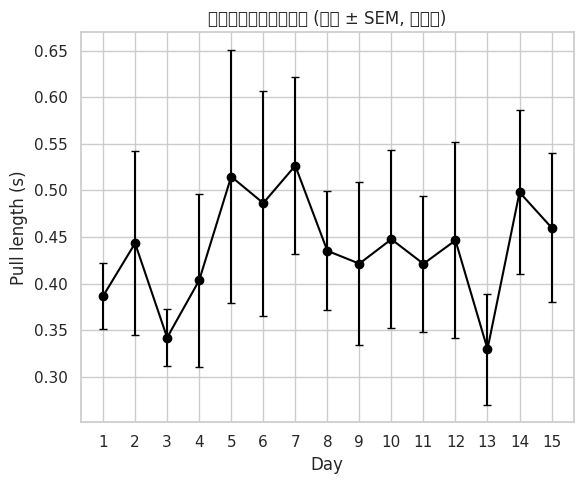

In [ ]:
# ---------- 個体平均 (group by day) ----------
grouped = res.groupby("day").agg(
    mean_pull_len=("pull_len_mean", "mean"),
    sem_pull_len=("pull_len_mean", lambda x: x.std(ddof=1) / (len(x)**0.5))
).reset_index()

# ---------- プロット ----------
plt.figure(figsize=(6, 5))
plt.errorbar(grouped["day"], grouped["mean_pull_len"],
             yerr=grouped["sem_pull_len"],
             marker="o", capsize=3, color="black")

plt.title("音無しレバー引き長さ (平均 ± SEM, 全個体)")
plt.xlabel("Day")
plt.ylabel("Pull length (s)")
plt.xticks(grouped["day"])
plt.grid(True)
plt.tight_layout()
plt.show()
